### import libraries for tf-idf and modeling

In [5]:
#general
import importlib.util
import sys
import pandas as pd
import os
import numpy as np
import re
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

In [6]:
#nlp
import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from gensim import corpora, models

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/armandalewis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
#scikit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [10]:
df_business = pd.read_json('/Users/armandalewis/Desktop/s_d/sd_proj/tf_idf_code/data/yelp_academic_dataset_business.json',lines=True)
df_user = pd.read_json('/Users/armandalewis/Desktop/s_d/sd_proj/tf_idf_code/data/yelp_academic_dataset_user.json',lines=True)
df_review = pd.read_json('/Users/armandalewis/Desktop/s_d/sd_proj/tf_idf_code/data/yelp_academic_dataset_review.json',lines=True)

In [11]:
cats = ['Restaurant', 'Restaurants', 'Cafes', 'Bakeries', 'Bars', 'Desserts', 'Coffee & Tea', 'Juice Bars & Smoothies', 'Food Trucks', 'Caterers', 'Coffee Roasteries', 'Delicatessen', 'Deli']
df_business = df_business[df_business['categories'].isin(cats)]

In [12]:
df_merged = df_review.merge(df_user, how='inner', left_on = ['user_id'], right_on = ['user_id'])
df_merged = df_merged.merge(df_business, how='inner', left_on = ['business_id'], right_on = ['business_id'])

In [18]:
df_yelp = df_merged[['review_id','user_id','business_id','name_y','name_x','stars_x','text']]
df_yelp.columns = ['review_id','user_id','business_id','resturant', 'user', 'rating','text']
#df_yelp

In [19]:
df_yelp.to_csv (r'yelp_consolidated.csv', index = False, header=True)

Text(0, 0.5, 'Num of reviews')

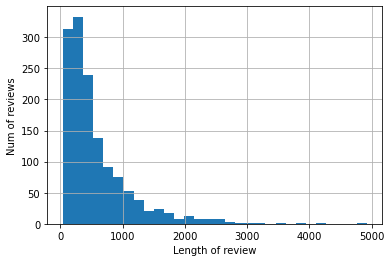

In [26]:
df_yelp.text.dropna().str.len().hist(bins=30)
plt.xlabel('Length of review')
plt.ylabel('Num of reviews')

In [31]:
df_yelp['txt_len'] = df_yelp['text'].apply(len)

/Users/armandalewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Length of review')

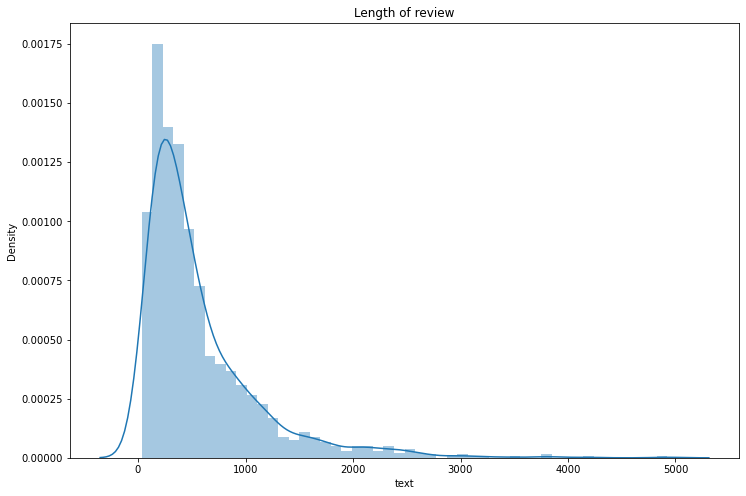

In [32]:
# Text Length
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(12,8))
sns.distplot(df_yelp.text.dropna().str.len(), kde=True, bins=50)
plt.title('Length of review')

Text(0, 0.5, 'Count')

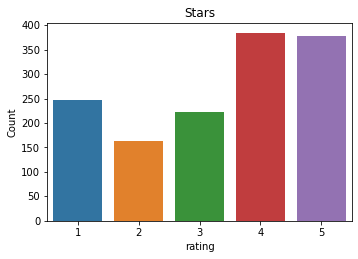

In [129]:
fig = plt.figure(figsize=(12,8))
axes1 = plt.subplot(2,2,1)
axes1 = sns.countplot(x='rating', data=df_yelp)
axes1.set_title('Stars')
axes1.set_ylabel('Count')

<AxesSubplot:xlabel='rating', ylabel='txt_len'>

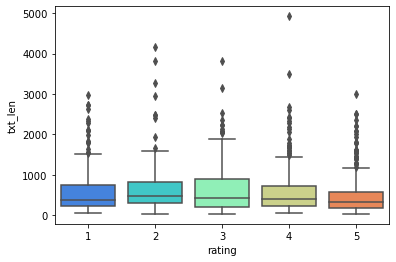

In [132]:
df_yelp['txt_len'] = df_yelp['text'].apply(len)
warnings.filterwarnings("ignore")
sns.boxplot(x='rating', y='txt_len', data=df_yelp, palette='rainbow')

In [81]:
df_yelp['predicted_rating'] = round(sum(df_yelp.rating)/len(df_yelp.review_id))

In [42]:
stoplist = set(stopwords.words("english"))

In [57]:
def process_reviews(dirty_data_set):
    clean_data_set = []
    for review in dirty_data_set:
        # Remove punctuations
        review = re.sub(r'[^a-zA-Z]', ' ', review)
        # To lowercase
        review = review.lower()
        # Remove stop words
        texts = [word for word in review.lower().split() if word not in stoplist]
        try:
            clean_data_set.append(' '.join(texts))
        except:
            pass
    return clean_data_set

def perform_lda(allReviewsTrain, numTopics):
    corpus = []
    for review in allReviewsTrain:
        # Remove punctuations
        review = re.sub(r'[^a-zA-Z]', ' ', review)
        # To lowercase
        review = review.lower()
        # Remove stop words
        texts = [word for word in review.lower().split() if word not in stoplist]
        try:
            corpus.append(texts)
        except:
            pass
           # Build dictionary
    dictionary = corpora.Dictionary(corpus)
    dictionary.save('restaurant_reviews.dict')
        
    # Build vectorized corpus
    corpus_2 = [dictionary.doc2bow(text) for text in corpus]
    #corpora.MmCorpus.serialize('LDA/restaurant_reviews.mm', corpus_2)
    
    lda = models.LdaModel(corpus_2, num_topics=numTopics, id2word=dictionary)
    return lda



# Generates a matrix of topic probabilities for each document in matrix
# Returns topic_dist for the input corpus, and all_dist, a running sum of all the corpuses
def generate_topic_dist_matrix(lda, numTopics, corpus, all_dist, star):
    topic_dist = [0] * numTopics
    dictionary = corpora.Dictionary.load("restaurant_reviews.dict")
    for doc in corpus:
        vec = dictionary.doc2bow(doc.lower().split())
        output = lda[vec]
        highest_prob = 0
        highest_topic = 0
        temp = [0] * numTopics    # List to keep track of topic distribution for each document
        for topic in output:
            this_topic, this_prob = topic
            temp[this_topic] = this_prob
            if this_prob > highest_prob:
                highest_prob = this_prob 
                highest_topic = this_topic
        temp.append(star)
        all_dist.append(temp)
        topic_dist[highest_topic] += 1
    return topic_dist, all_dist

In [107]:
reviews = df_yelp.groupby('rating')

all_1reviews = reviews.get_group(1.0)['text']
all_2reviews = reviews.get_group(2.0)['text']
all_3reviews = reviews.get_group(3.0)['text']
all_4reviews = reviews.get_group(4.0)['text']
all_5reviews = reviews.get_group(5.0)['text']

all_1labels = [1.0]*len(all_1reviews)
all_2labels = [2.0]*len(all_2reviews)
all_3labels = [3.0]*len(all_3reviews)
all_4labels = [4.0]*len(all_4reviews)
all_5labels = [5.0]*len(all_5reviews)

In [108]:
all_1reviews_train, all_1reviews_test, all_1labels_train, all_1labels_test = train_test_split(all_1reviews, all_1labels, test_size=0.20, random_state=123)
all_2reviews_train, all_2reviews_test, all_2labels_train, all_2labels_test = train_test_split(all_2reviews, all_2labels, test_size=0.20, random_state=123)
all_3reviews_train, all_3reviews_test, all_3labels_train, all_3labels_test = train_test_split(all_3reviews, all_3labels, test_size=0.20, random_state=123)
all_4reviews_train, all_4reviews_test, all_4labels_train, all_4labels_test = train_test_split(all_4reviews, all_4labels, test_size=0.20, random_state=123)
all_5reviews_train, all_5reviews_test, all_5labels_train, all_5labels_test = train_test_split(all_5reviews, all_5labels, test_size=0.20, random_state=123)

In [109]:
# Process the reviews
corpus_5stars = process_reviews(all_5reviews_train)
corpus_4stars = process_reviews(all_4reviews_train)
corpus_3stars = process_reviews(all_3reviews_train)
corpus_2stars = process_reviews(all_2reviews_train)
corpus_1stars = process_reviews(all_1reviews_train)

print ("Number of 5-star reviews now: ", len(corpus_5stars))
print ("Number of 4-star reviews now: ", len(corpus_4stars))
print ("Number of 3-star reviews now: ", len(corpus_3stars))
print ("Number of 2-star reviews now: ", len(corpus_2stars))
print ("Number of 1-star reviews now: ", len(corpus_1stars))

Number of 5-star reviews now:  301
Number of 4-star reviews now:  308
Number of 3-star reviews now:  178
Number of 2-star reviews now:  131
Number of 1-star reviews now:  197


In [110]:
all_5_4_train = np.append(corpus_5stars, corpus_4stars)
all_5_4_3_train = np.append(all_5_4_train, corpus_3stars)
all_5_4_3_2_train = np.append(all_5_4_3_train, corpus_2stars)
all_text_train = np.append(all_5_4_3_2_train, corpus_1stars)

In [111]:
numTopics = 15
%time lda = perform_lda(all_text_train, numTopics)

CPU times: user 1.48 s, sys: 119 ms, total: 1.6 s
Wall time: 1.82 s


In [112]:
topic_dist_list = []

# Keep a separate list to count topics
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []

topic_dist_5stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_5stars, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_4stars, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_3stars, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_2stars, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_1stars, topic_dist_list, 1)

cols = []
for i in range(1, numTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")

topic_dist_train_1_2_3_4_5_df = pd.DataFrame(topic_dist_list, columns=cols)


In [113]:
# Process the test reviews
corpus_5stars = process_reviews(all_5reviews_test)
corpus_4stars = process_reviews(all_4reviews_test)
corpus_3stars = process_reviews(all_3reviews_test)
corpus_2stars = process_reviews(all_2reviews_test)
corpus_1stars = process_reviews(all_1reviews_test)

In [114]:
all_5_4_test = np.append(corpus_5stars, corpus_4stars)
all_5_4_3_test = np.append(all_5_4_test, corpus_3stars)
all_5_4_3_2_test = np.append(all_5_4_3_test, corpus_2stars)
all_text_test = np.append(all_5_4_3_2_test, corpus_1stars)

In [115]:
topic_dist_list = []

# Keep a separate list to count topics
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []


topic_dist_5stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_5stars, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_4stars, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_3stars, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_2stars, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_1stars, topic_dist_list, 1)

cols = []
for i in range(1, numTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")

topic_dist_test_1_2_3_4_5_df = pd.DataFrame(topic_dist_list, columns=cols)

In [123]:
#topic_dist_test_1_2_3_4_5_df.shape
#topic_dist_train_1_2_3_4_5_df.shape

(281, 16)

In [117]:
vectorizer = TfidfVectorizer()

tfidf_xtrain = vectorizer.fit_transform(all_text_train)
tfidf_xtest = vectorizer.transform(all_text_test)

tfidf_ytrain = topic_dist_train_1_2_3_4_5_df['Star']
tfidf_ytest = topic_dist_test_1_2_3_4_5_df['Star']

In [127]:
tfidf_ytest

0      5
1      5
2      5
3      5
4      5
      ..
276    1
277    1
278    1
279    1
280    1
Name: Star, Length: 281, dtype: int64

In [128]:
clfs = [MultinomialNB(), LogisticRegression()]

clf_names = ['Multinomial NB', 'Logistic Regression']

NBResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(tfidf_xtrain, tfidf_ytrain)
    preds = clf.predict(tfidf_xtest)
    
    precision = metrics.precision_score(tfidf_ytest, preds, average='weighted')
    recall = metrics.recall_score(tfidf_ytest, preds, average='weighted')
    f1 = metrics.f1_score(tfidf_ytest, preds, average='weighted')
    accuracy = accuracy_score(tfidf_ytest, preds)
    report = classification_report(tfidf_ytest, preds)
    matrix = metrics.confusion_matrix(tfidf_ytest, preds)
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    NBResults[clf_names[i]] = data

cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(NBResults).T[cols].T

,Multinomial NB,Logistic Regression
precision,0.382523,0.533266
recall,0.362989,0.462633
f1_score,0.296282,0.423209
accuracy,0.362989,0.462633
